In [90]:
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy,copy
from myDataset import PalmNutriDataset

# the magic number
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

ground_truth = 'dataset/gt.csv'
full_dataset = PalmNutriDataset(ground_truth=ground_truth, img_dir='dataset', sample_set='n17')
print(len(full_dataset))

1018


In [91]:
# train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [800,218])
# train_dataset.dataset = copy(full_train_dataset)
full_dataset.transform = preprocess
# val_dataset.dataset.transform = preprocess

In [92]:
BATCH_SIZE=16
NUM_WORKERS=2
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE,shuffle=True , num_workers=NUM_WORKERS)

In [93]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

model = models.alexnet()
model.classifier[6] = torch.nn.Linear(in_features=4096,out_features=1)
model.load_state_dict(torch.load('current_model/alex_sgd_0.01.pth'))
model.eval()
model.to(device)

cuda:1


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [94]:
import matplotlib.pyplot as plt
import numpy as np
all_preds = None
all_labels = None
with torch.no_grad():
    for index, (inputs,labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.view(-1,1).to(device)
        # print(inputs,labels)
        preds = model(inputs)
        if(all_preds == None):
            all_preds = preds.cpu().view(-1)
            all_labels = labels.cpu().view(-1)
        else:
            all_preds = torch.cat( [all_preds,preds.cpu().view(-1)],dim=0)
            all_labels = torch.cat( [all_labels,labels.cpu().view(-1)],dim=0)
        # print(all_preds.shape, all_labels.shape)
        # plt.scatter((index * 16) + np.arange(16),preds.cpu(),label='prediction')
        # plt.scatter((index * 16) + np.arange(16),labels.cpu(),label='target')
        # if(index == 2):
        #     break

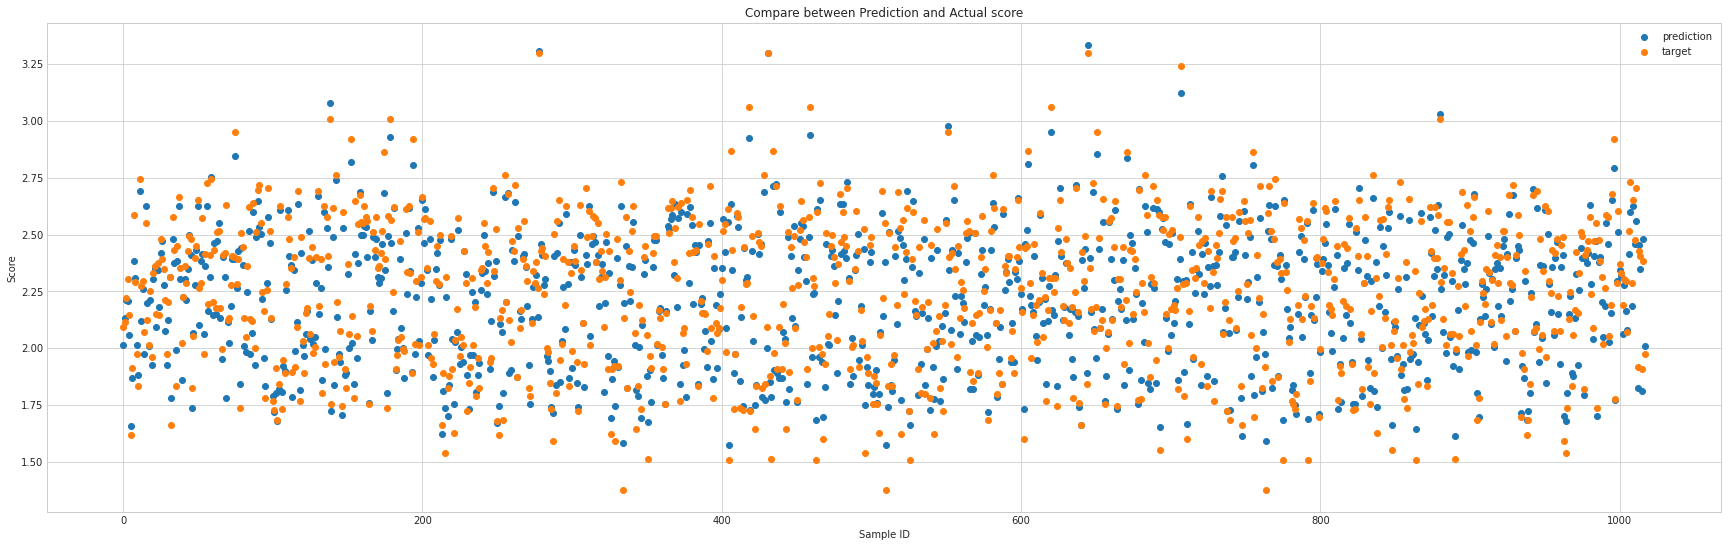

In [95]:
plt.style.use('seaborn-whitegrid')
fig,ax = plt.subplots(figsize=(30,9))
ax.scatter(np.arange(len(all_preds)),all_preds,label='prediction')
ax.scatter(np.arange(len(all_labels)),all_labels,label='target')
ax.set_title('Compare between Prediction and Actual score')
ax.set_ylabel('Score')
ax.set_xlabel('Sample ID')
ax.legend()
plt.show()

In [102]:
import math
def get_class(score):
    n_range = [0,2.3,2.4,3,math.inf]
    if(score < 2):
        return 1
    if(score < 2.4):
        return 2
    if(score < 3):
        return 3
    else: return 4


In [103]:
acc = 0
acc_class = dict()
len_class = dict()
err = 0
err_class = dict()
class_3 = []
for idx in range(len(all_preds)):
    pred,label = all_preds[idx], all_labels[idx]
    class_pred = get_class(pred)
    class_act = get_class(label)
    
    if(class_act not in len_class.keys()):
        acc_class[class_act] = 0
        err_class[class_act] = 0
        len_class[class_act] = 1

    if(class_act == class_pred):
        acc += 1
        acc_class[class_act] += 1
    len_class[class_act] += 1
    err += abs(pred - label)
    err_class[class_act] += abs(pred - label)
    if(class_act == 3 and class_pred != 3):
        class_3.append((full_dataset.filenames[idx],pred,label))

print('Over All acc: ',acc/len(all_preds) * 100)
print('Over All err: ',err/len(all_preds))

for k,v in acc_class.items():
    print(f"Acc of Class {k}: {v}/{len_class[k]} = {v/len_class[k] * 100}")
    print(f"Err of Class {k}: {err_class[k]/len_class[k]}")

Over All acc:  84.18467583497053
Over All err:  tensor(0.0661)
Acc of Class 2: 335/395 = 84.81012658227847
Err of Class 2: 0.06019742786884308
Acc of Class 1: 233/244 = 95.49180327868852
Err of Class 1: 0.06717731803655624
Acc of Class 3: 283/372 = 76.0752688172043
Err of Class 3: 0.07103151082992554
Acc of Class 4: 6/11 = 54.54545454545454
Err of Class 4: 0.063127800822258


N33_17_3.JPG 2.3846845626831055 2.5859999656677246


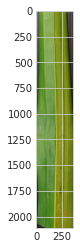

N47_17_1.JPG 2.3852696418762207 2.4519999027252197


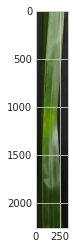

N51_17_2.JPG 2.3482608795166016 2.428999900817871


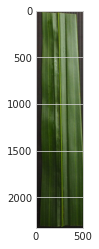

N58_17_3.JPG 2.3151612281799316 2.4119999408721924


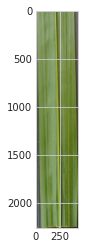

N61_17_5.JPG 2.313286781311035 2.4210000038146973


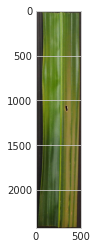

N62_17_2.JPG 1.781694769859314 2.628999948501587


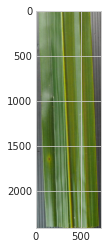

N65_17_4.JPG 2.3674182891845703 2.446000099182129


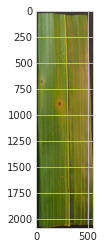

N153_17_2.JPG 2.288036823272705 2.4019999504089355


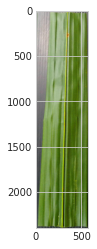

N162_17_5.JPG 2.3763256072998047 2.5480000972747803


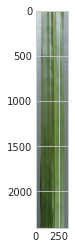

N167_17_3.JPG 2.3074564933776855 2.4170000553131104


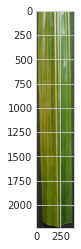

N172_17_2.JPG 2.394810199737549 2.4739999771118164


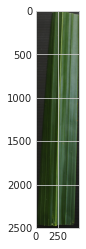

N191_17_2.JPG 2.340937614440918 2.447999954223633


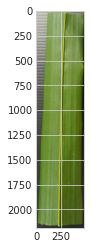

N193_17_4.JPG 2.3827996253967285 2.5250000953674316


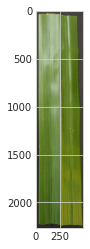

N204_17_3.JPG 2.3033828735351562 2.4079999923706055


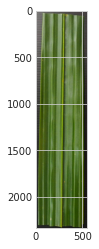

N213_17_4.JPG 2.3707337379455566 2.48799991607666


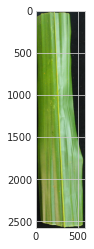

N216_17_4.JPG 2.312164783477783 2.428999900817871


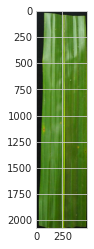

N218_17_5.JPG 2.330176830291748 2.428999900817871


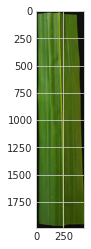

N220_17_2.JPG 2.3967764377593994 2.4790000915527344


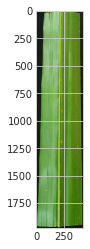

N223_17_1.JPG 2.3631491661071777 2.430000066757202


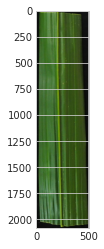

N223_17_4.JPG 2.357707977294922 2.5169999599456787


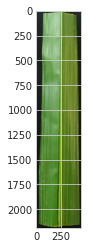

N226_17_4.JPG 2.325096845626831 2.4019999504089355


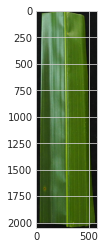

N226_17_5.JPG 2.3889529705047607 2.450000047683716


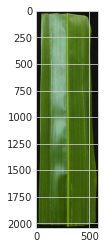

N236_17_3.JPG 2.2888121604919434 2.4210000038146973


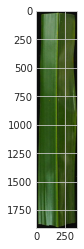

N237_17_2.JPG 2.1929566860198975 2.421999931335449


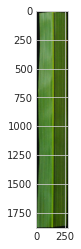

N246_17_1.JPG 2.3457303047180176 2.433000087738037


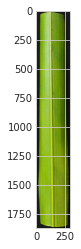

N263_17_3.JPG 2.294245719909668 2.4010000228881836


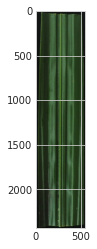

N277_17_4.JPG 2.378951072692871 2.453000068664551


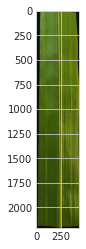

N280_17_4.JPG 2.3776705265045166 2.5510001182556152


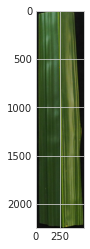

N288_17_2.JPG 2.331197500228882 2.444999933242798


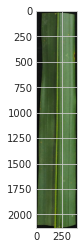

N298_17_3.JPG 2.3801660537719727 2.509000062942505


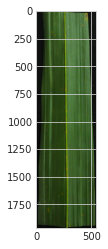

N302_17_2.JPG 2.3278021812438965 2.4000000953674316


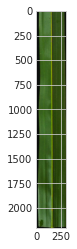

N308_17_4.JPG 2.289924383163452 2.4079999923706055


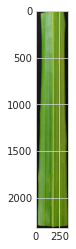

N310_17_4.JPG 2.3056161403656006 2.4000000953674316


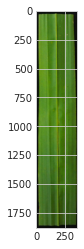

N311_17_1.JPG 2.384136438369751 2.444999933242798


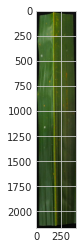

N321_17_4.JPG 2.374329090118408 2.4800000190734863


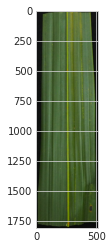

N331_17_3.JPG 2.3919196128845215 2.575000047683716


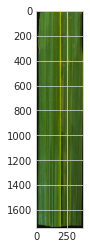

N332_17_2.JPG 2.3014283180236816 2.444999933242798


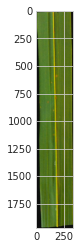

N347_17_1.JPG 2.394620180130005 2.48799991607666


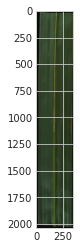

N351_17_2.JPG 2.325540542602539 2.4549999237060547


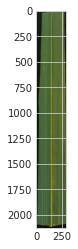

N353_17_1.JPG 2.3593549728393555 2.427999973297119


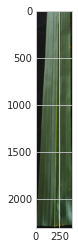

N354_17_4.JPG 2.368246078491211 2.4549999237060547


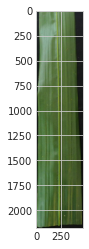

N362_17_2.JPG 2.2913713455200195 2.507999897003174


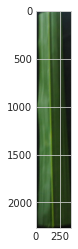

N364_17_2.JPG 2.313042640686035 2.4119999408721924


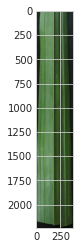

N367_17_4.JPG 2.364824056625366 2.4800000190734863


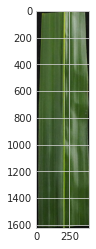

N374_17_3.JPG 2.391695737838745 2.4749999046325684


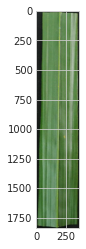

N378_17_4.JPG 2.3927507400512695 2.4800000190734863


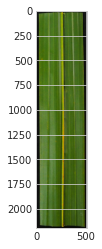

N383_17_2.JPG 2.3517937660217285 2.4600000381469727


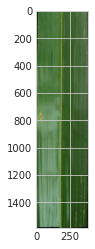

N384_17_3.JPG 2.3768386840820312 2.441999912261963


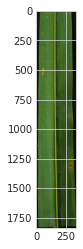

N386_17_2.JPG 2.3440637588500977 2.4079999923706055


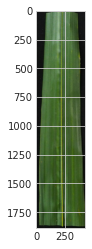

N388_17_2.JPG 2.3186089992523193 2.4040000438690186


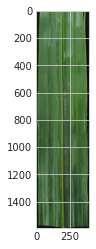

N392_17_5.JPG 2.3229146003723145 2.4149999618530273


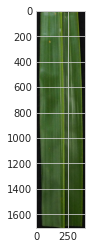

N410_17_4.JPG 2.3469858169555664 2.430999994277954


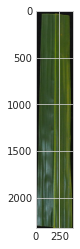

N411_17_2.JPG 2.375375747680664 2.628999948501587


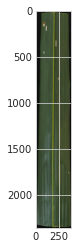

N417_17_5.JPG 2.3500967025756836 2.4119999408721924


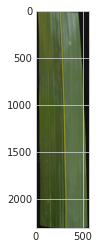

N418_17_3.JPG 2.3753538131713867 2.4549999237060547


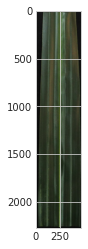

N427_17_4.JPG 2.366753578186035 2.4800000190734863


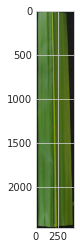

N430_17_3.JPG 2.3594398498535156 2.430999994277954


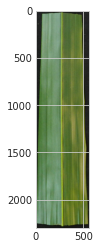

N432_17_3.JPG 2.356309175491333 2.453000068664551


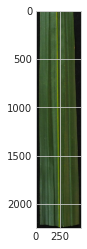

N435_17_3.JPG 2.3285436630249023 2.421999931335449


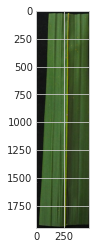

N437_17_1.JPG 2.3963122367858887 2.494999885559082


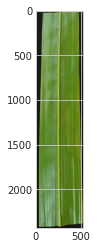

N440_17_3.JPG 2.379415512084961 2.4749999046325684


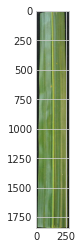

In [118]:
import matplotlib.image as mpimg
preds = []
acts = []
names = []
for name,pred,act in class_3:
    names.append(name)
    preds.append(pred)
    acts.append(act)

    if(abs(pred - act) > 0.06 ):
        print(name, float(pred), float(act))
        img = mpimg.imread(f'dataset/n17/{name}')
        imgplot = plt.imshow(img)
        plt.show()

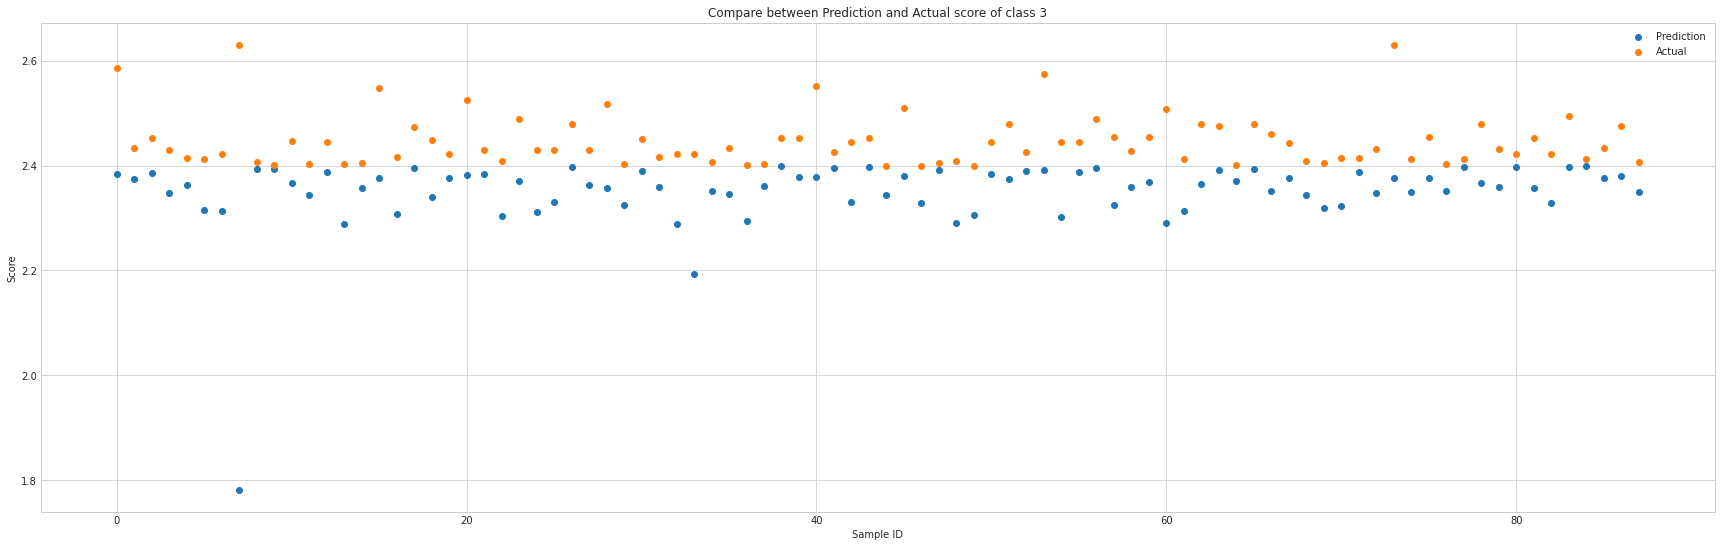

In [105]:
fig,ax = plt.subplots(figsize=(30,9))
ax.scatter(range(len(preds)),preds,label='Prediction')
ax.scatter(range(len(acts)),acts,label='Actual')
ax.legend()
ax.set_title('Compare between Prediction and Actual score of class 3')
ax.set_ylabel('Score')
ax.set_xlabel('Sample ID')
plt.show()

In [ ]:
import matplotlib.image as mpimg
img = mpimg.imread('your_image.png')
imgplot = plt.imshow(img)
plt.show()